<a href="https://colab.research.google.com/github/fadlymuham1/fraud_prediction/blob/main/Fraud_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Necessary module
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Data Source : https://www.kaggle.com/datasets/ealaxi/paysim1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

In [4]:
os.getcwd()

'/content'

In [5]:
os.chdir('/content/drive/MyDrive/Python Projects/Fraud Detection/')

In [6]:
data =pd.read_csv('/content/drive/MyDrive/Python Projects/Fraud Detection/PS_20174392719_1491204439457_log.csv')

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
print(len(data))

6362620


In [ ]:
#Installing the library 
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 5.4 MB/s 


In [ ]:
#Importing the library 
import sweetviz as sv

In [ ]:
report = sv.analyze(data)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



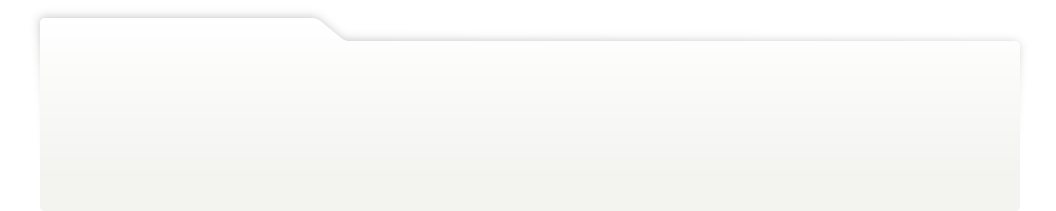
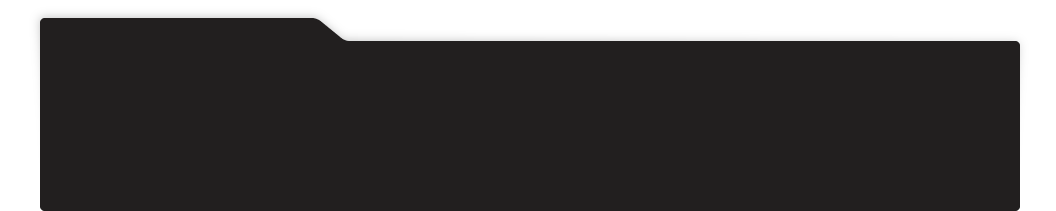
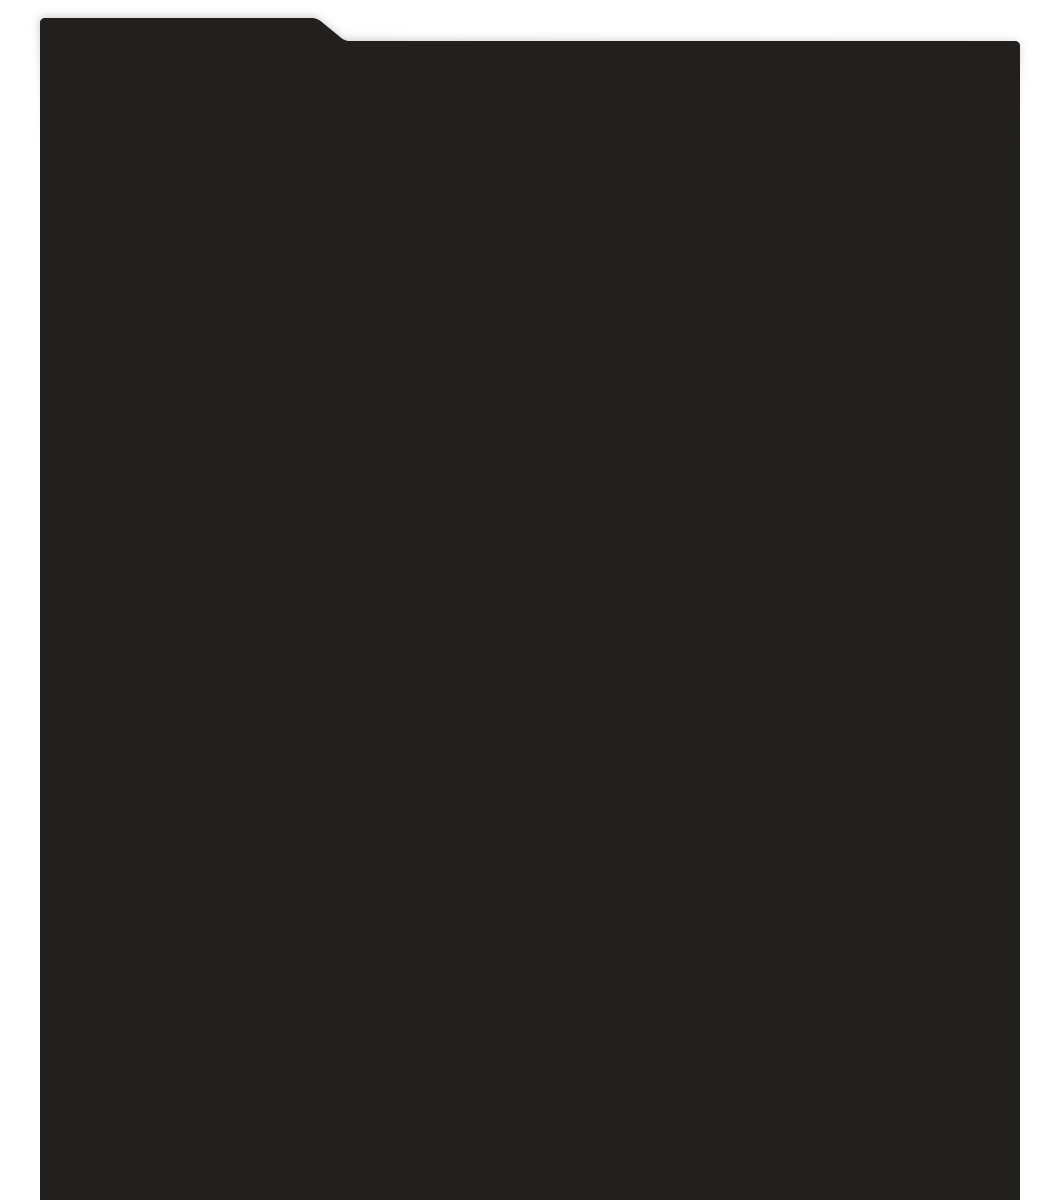
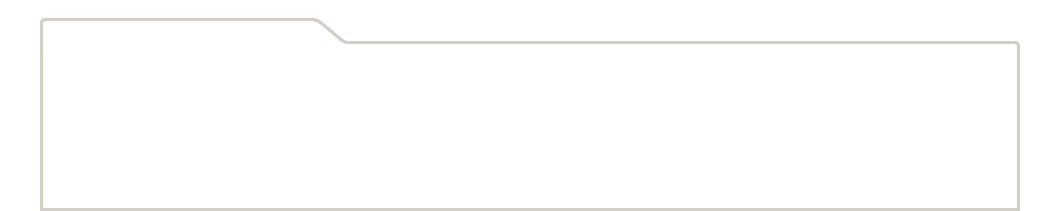
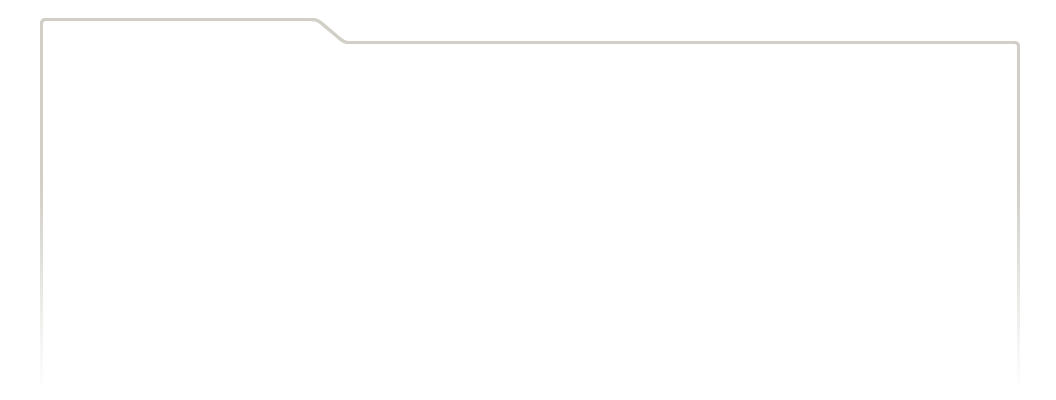
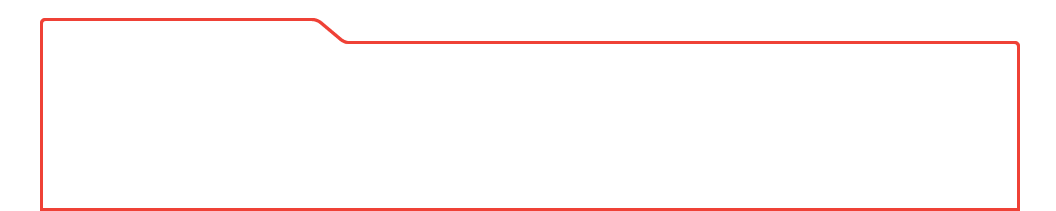
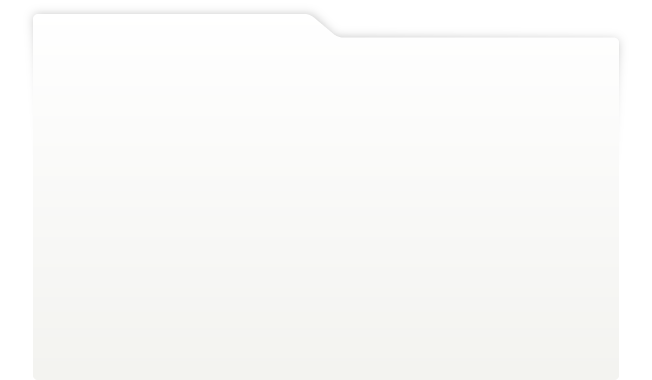
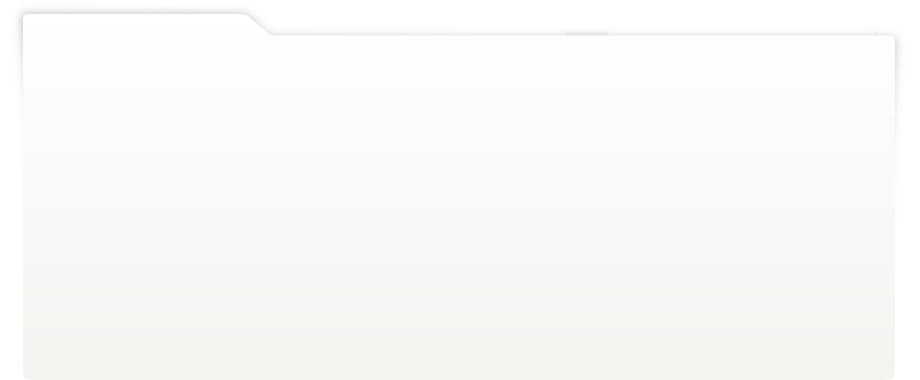
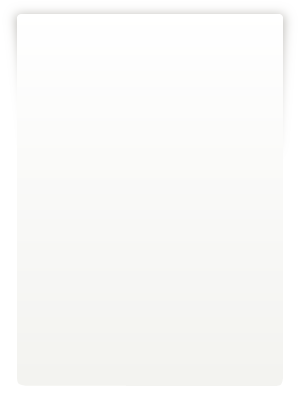
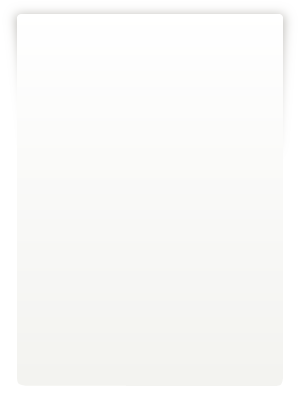
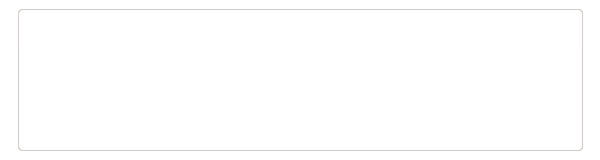
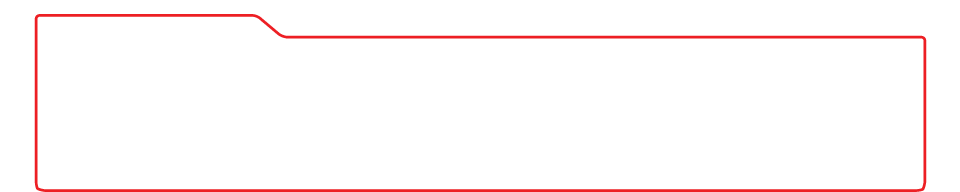
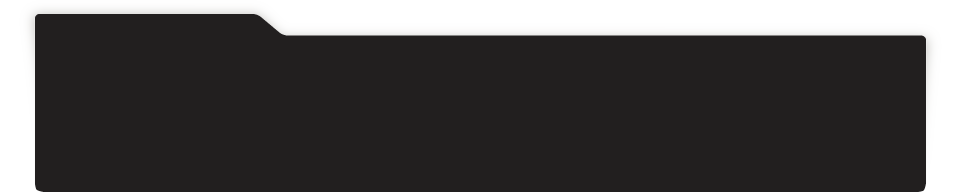
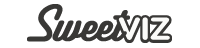
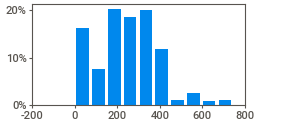
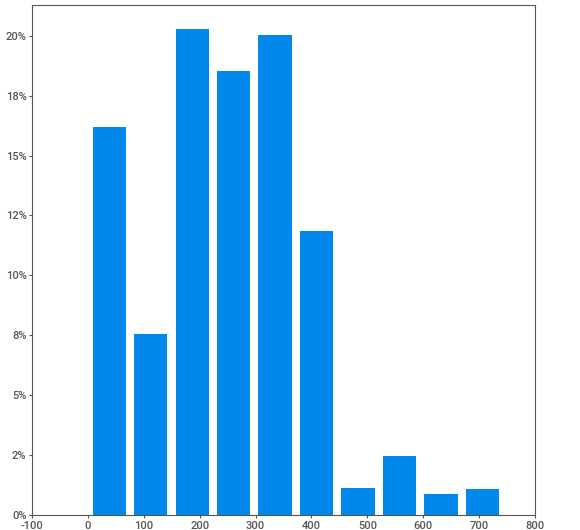
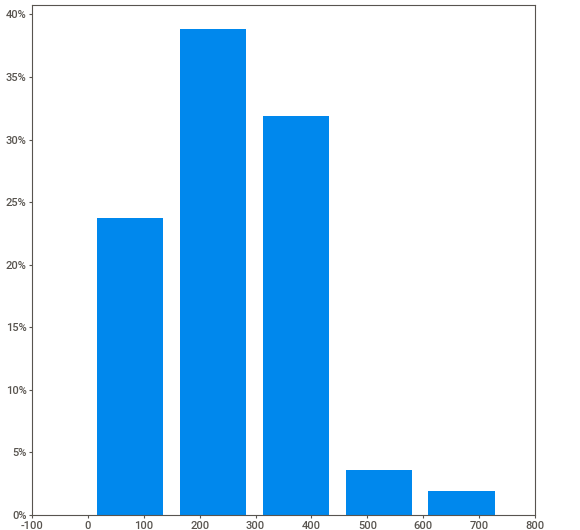
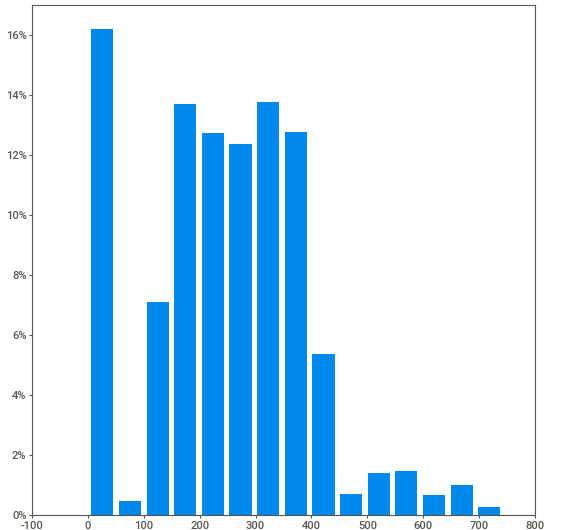
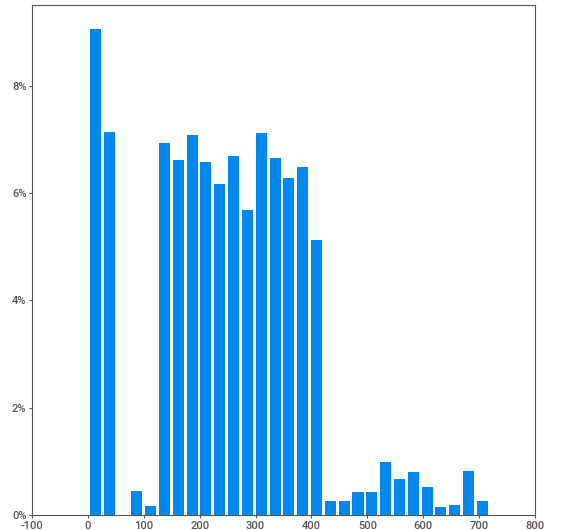
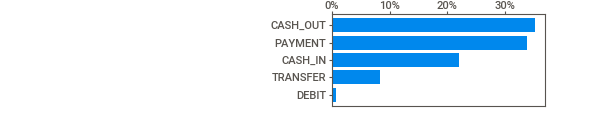
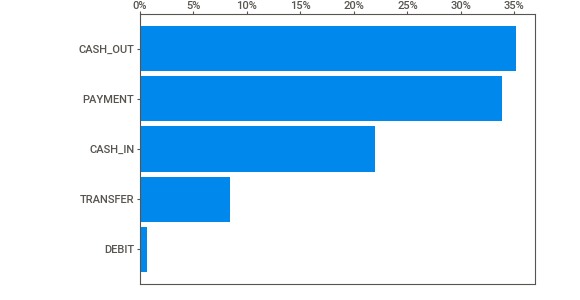
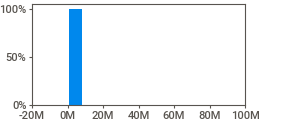
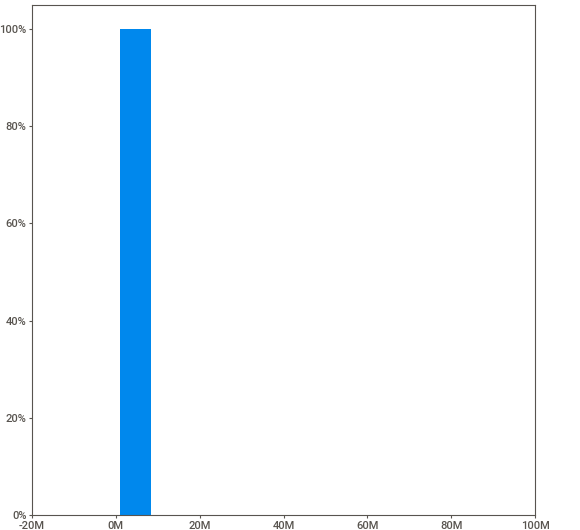
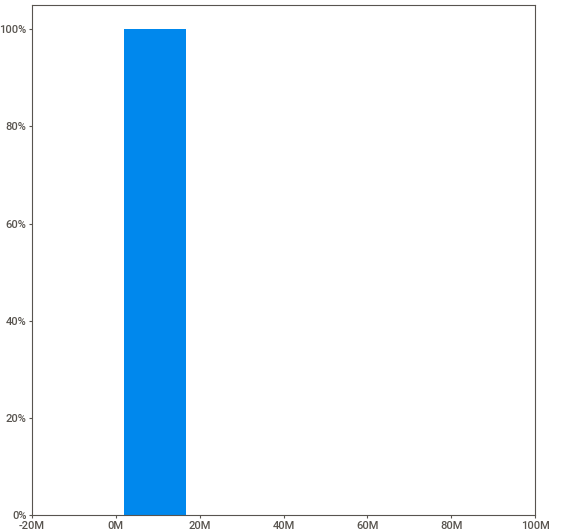
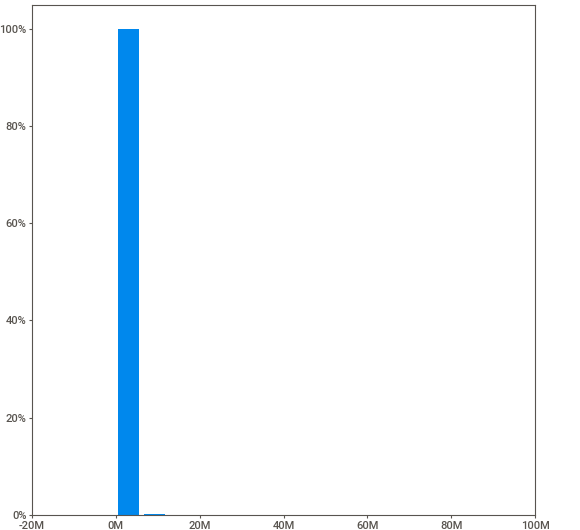
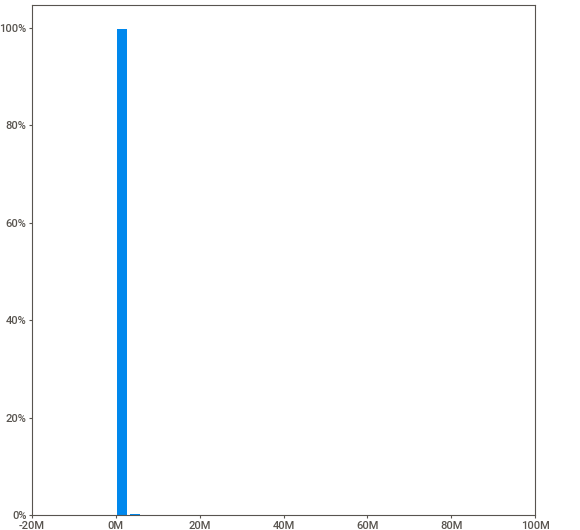
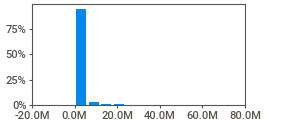
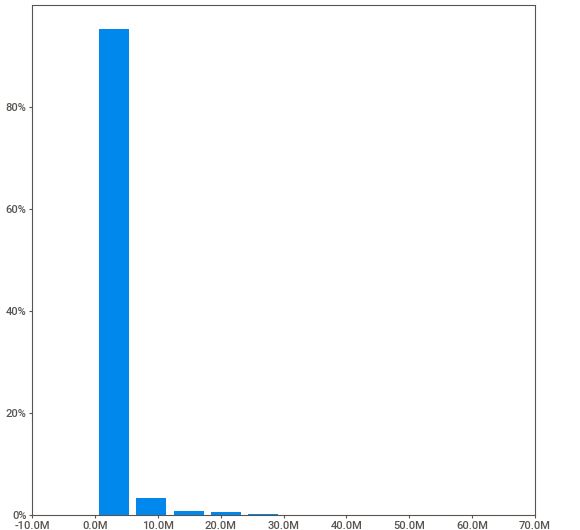
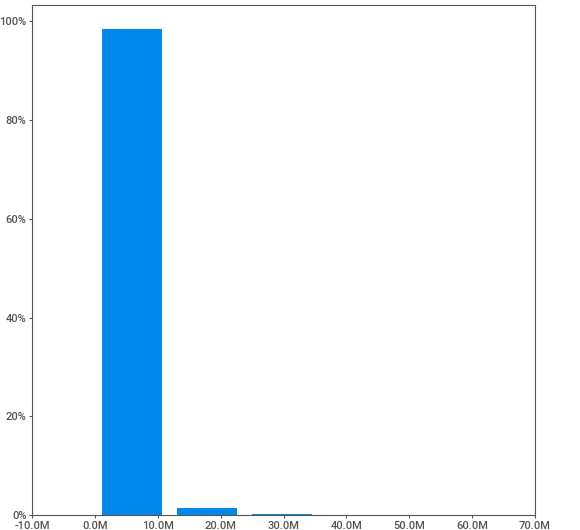
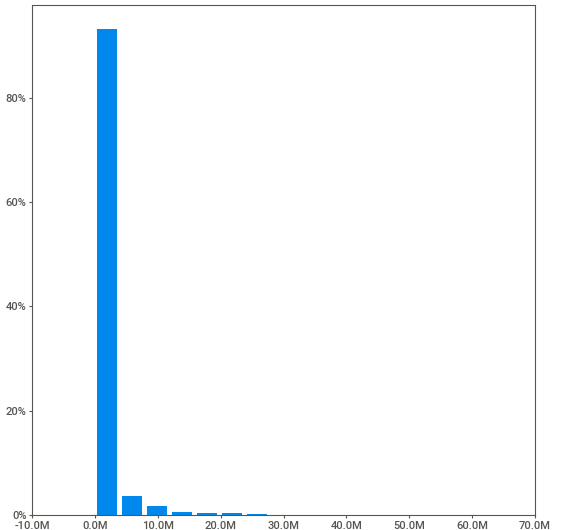
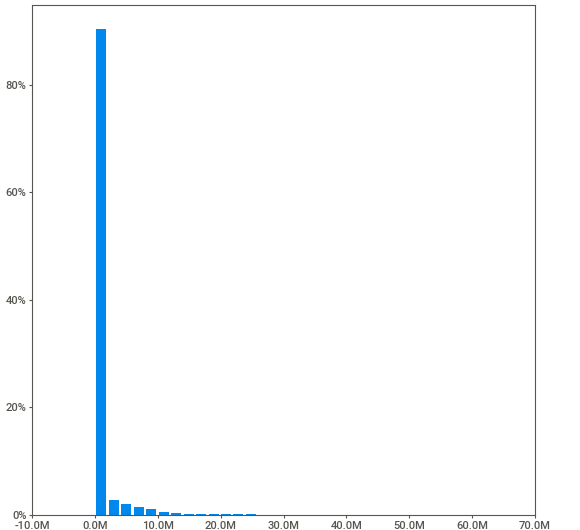
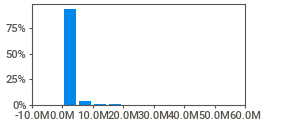
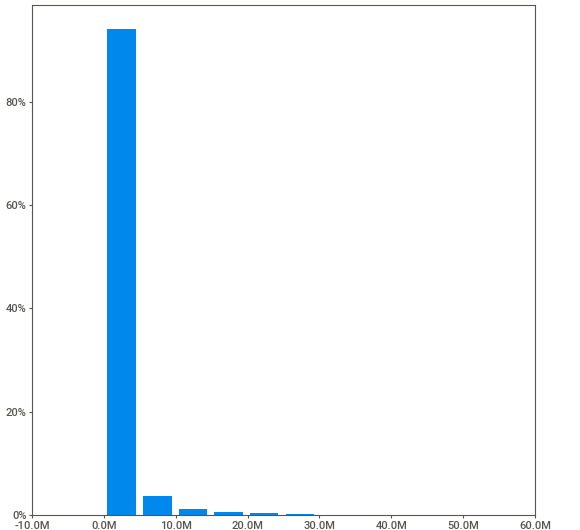
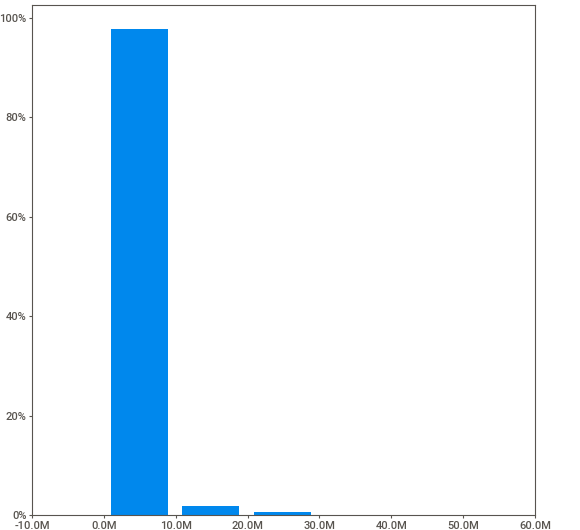
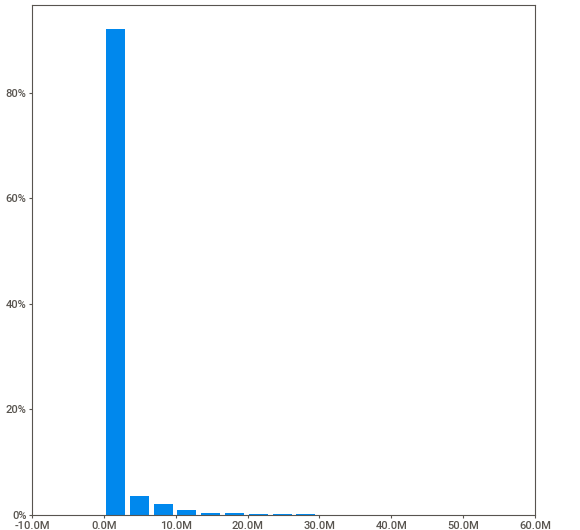
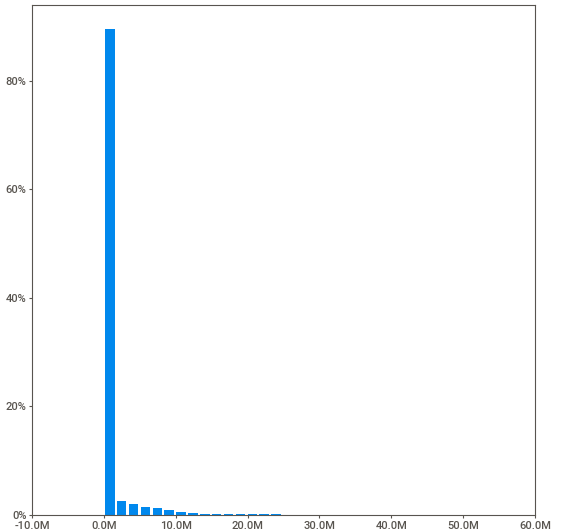
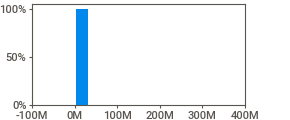
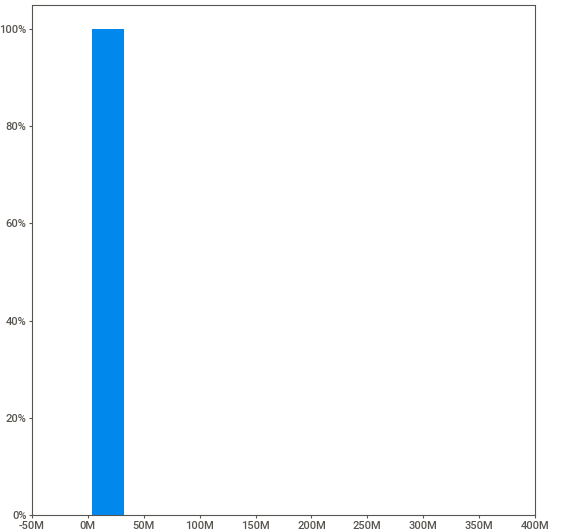
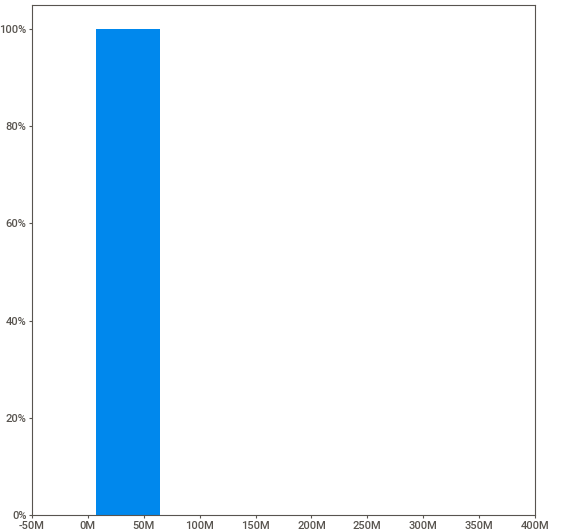
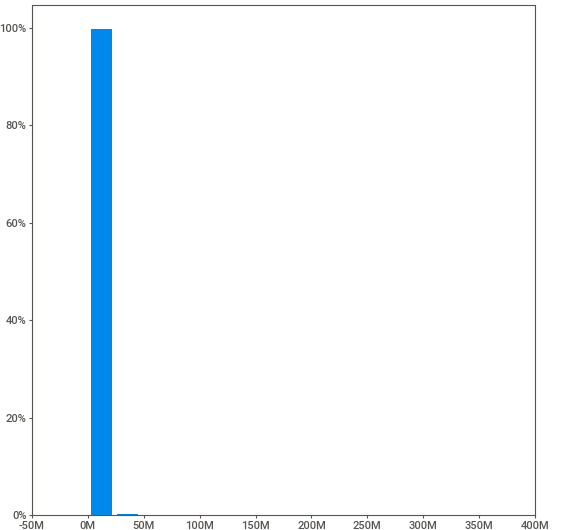
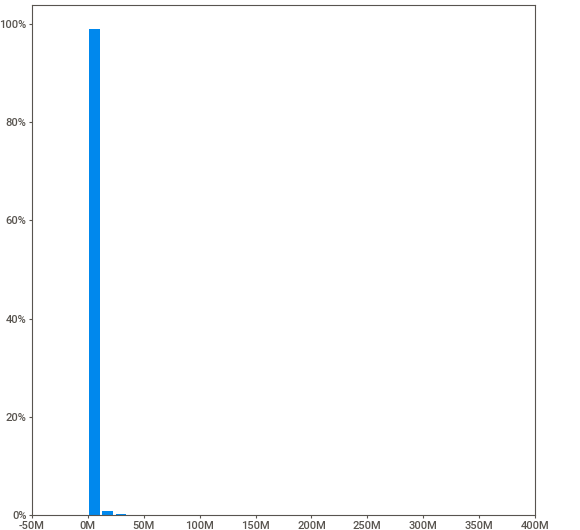
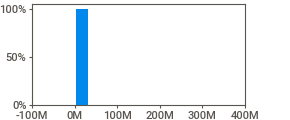
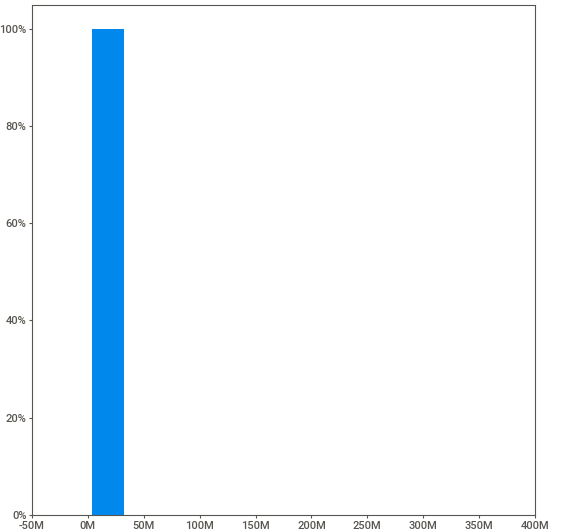
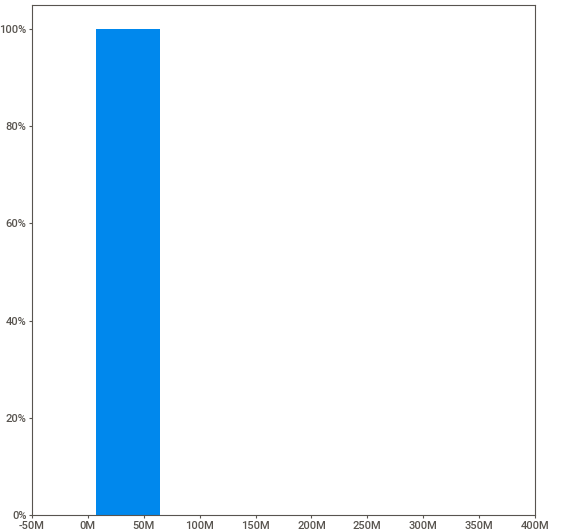
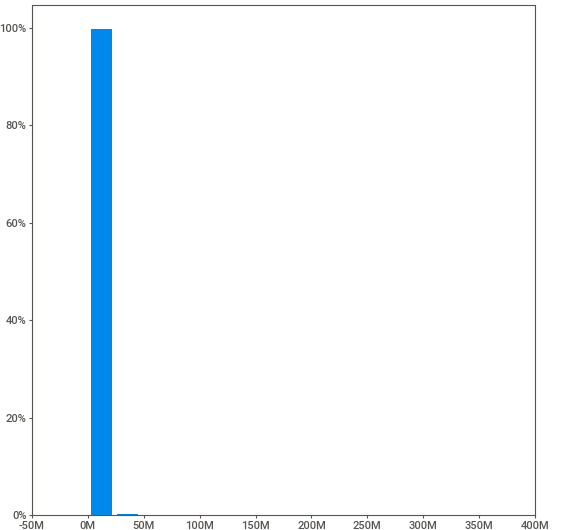
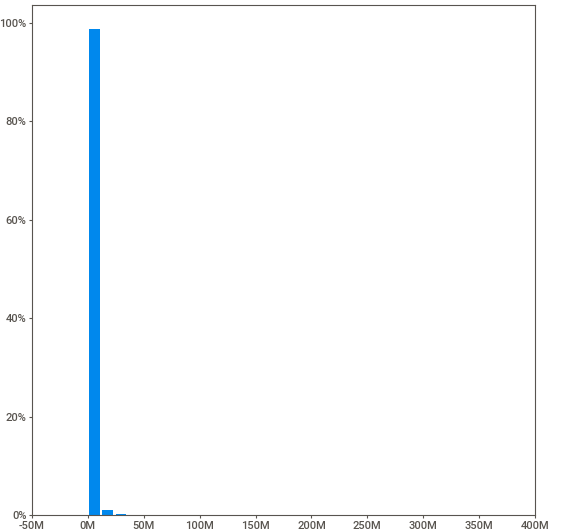
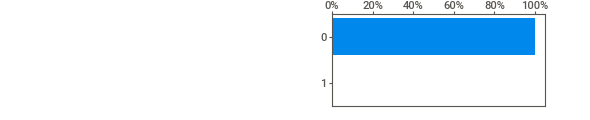
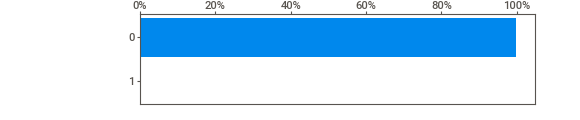
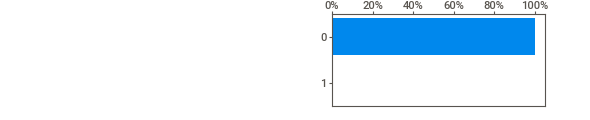
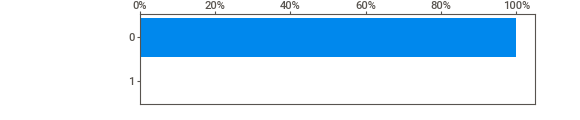
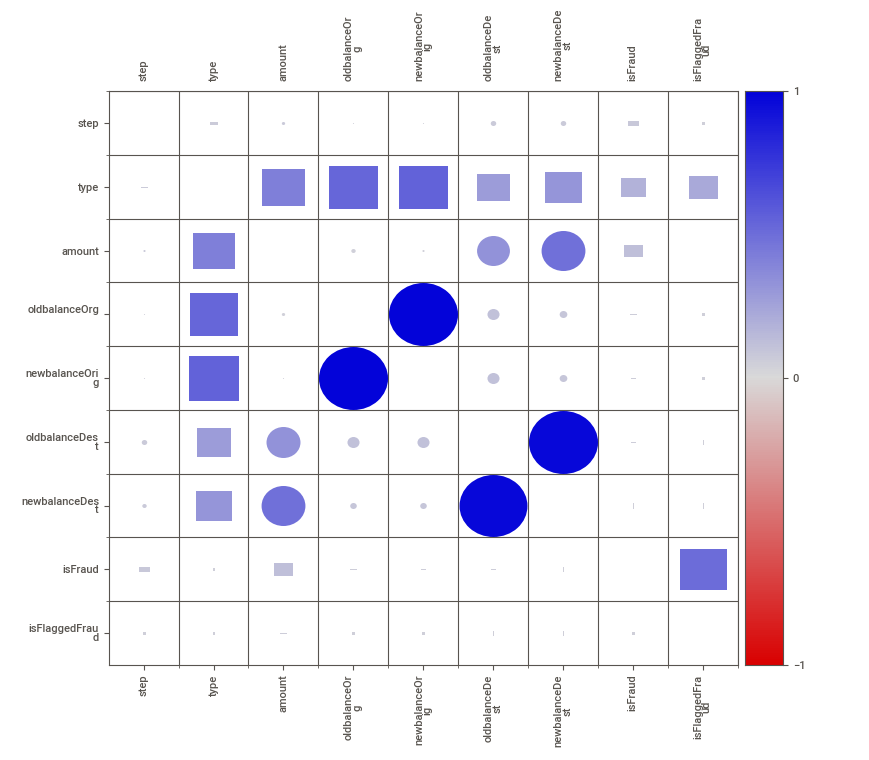
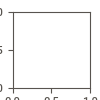

In [ ]:
report.show_notebook()

1. The Label is imbalance, need to do something (Oversampling, Undersampling, Weighting , SMOTE)
2. There are 16 zero rows on Amount Column
2. Despite there are some outliers within 'amount' column, it seems like it is actually natural outlier, as one of the fraudster common motive is to do transfer in bulk as they have only limited time to do fraud. The Transaction should be flagged in 'isFlaggedFraud' column
3. Old balance of Customer - New Balance of Customer = New balance of Fraudster - Old balance of Fraudster -- This is according to the description of the data in here that the fraudulent act that happens is fraudster took money from other account.

### Check if The lost balance in Victim account equals to received balance in fraudster account###

In [9]:
data['correct_value'] = (data['oldbalanceOrg'] - data['newbalanceOrig'] ) ==  (data['newbalanceDest'] - data['oldbalanceDest'])

In [10]:
data['correct_value'].value_counts()

False    5346209
True     1016411
Name: correct_value, dtype: int64

It seems that thats not always the case (similarity of loss balance with received balance). As the information from the source is very limited, we cannot find a justification to eliminate any rows using these 4 columns

### Drop obs with Amount Zero

In [11]:
data['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [12]:
data  = data[data['amount']>0]

In [13]:
print(len(data))

6362604


### Check if the outlier in 'amount' column has been already flaged properly in isFlaggedFraud

In [14]:
data_outlier_amount = data[data['amount']>500000]
data_outlier_amount[['isFlaggedFraud','amount']].groupby('isFlaggedFraud').count()

,amount
isFlaggedFraud,
0,340270
1,14


It seems that these outlier values hasn't been properly flagged, so we could say it is not natural outlier, and need to be dropped.

This time we are using IQR Method to drop any data beyond 25-75 percentile

In [15]:
Q1,Q3 = np.percentile(data['amount'], [25,75])

In [16]:
Q1

13389.75

In [17]:
Q3

208721.8175

In [18]:
IQR = Q3 - Q1

In [19]:
data = data[~((data['amount'] < (Q1 - 1.5 * IQR)) |(data['amount'] > (Q3 + 1.5 * IQR)))]

In [20]:
print(len(data))

6024527


Distribution of Label of each type of transaction

In [21]:
data[['isFraud','type','nameOrig']].groupby(['type','isFraud']).count()

nameOrig
type     isFraud          
CASH_IN  0         1373826
CASH_OUT 0         2183053
         1            2181
DEBIT    0           41430
PAYMENT  0         2151495
TRANSFER 0          270380
         1            2162

Only  Cash out and Transfer that has Fraud cases. So observations other than those two types need to be dropped as well

In [22]:
data = data[(data['type'] == 'CASH_OUT') |( data['type'] == 'TRANSFER')]

In [23]:
print(len(data))

2457776


## Visualize Correlation ( If Any)

In [24]:
data_some = data[['amount','oldbalanceOrg', 'newbalanceOrig',
                          'oldbalanceDest', 'newbalanceDest']].copy()

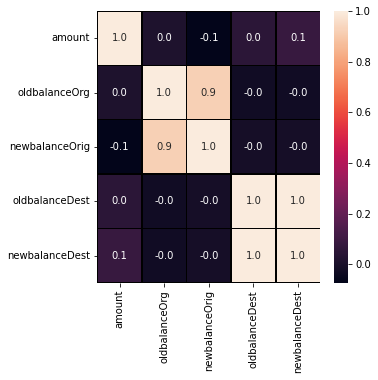

In [25]:
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(data_some.corr(),annot=True,linewidths=0.5,linecolor="black",fmt=".1f",ax=ax)
plt.show()

The Before-after balance columns are (obviously!) highly correlated. And thus only one of them need to be used

### Prepare Training and Testing Dataset

In [26]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'correct_value'],
      dtype='object')

In [27]:
column_used = [ 'type', 'amount', 'oldbalanceOrg',
               'newbalanceDest', 'isFraud',
              'isFlaggedFraud']
data_model = data[column_used].copy()

In [28]:
#encode nominal variable (categorical variable)
nominal_type = pd.get_dummies(data_model['type'],drop_first = True)

In [29]:
nominal_type.head()

,TRANSFER
2,1
3,0
15,0
19,1
24,1


In [30]:
data_model = pd.concat([data_model,nominal_type],axis = 1)

In [31]:
data_model.head()

,type,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud,TRANSFER
2,TRANSFER,181.00,181.0,0.00,1,0,1
3,CASH_OUT,181.00,181.0,0.00,1,0,0
15,CASH_OUT,229133.94,15325.0,51513.44,0,0,0
19,TRANSFER,215310.30,705.0,0.00,0,0,1
24,TRANSFER,311685.89,10835.0,2719172.89,0,0,1


In [32]:
data_model = data_model.drop('type', axis = 1)

In [33]:
data_model.head()

,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud,TRANSFER
2,181.00,181.0,0.00,1,0,1
3,181.00,181.0,0.00,1,0,0
15,229133.94,15325.0,51513.44,0,0,0
19,215310.30,705.0,0.00,0,0,1
24,311685.89,10835.0,2719172.89,0,0,1


In [34]:
print(len(data_model))

2457776


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [36]:
target_column = ['isFraud']

In [37]:
x = data_model.drop(target_column,axis= 1).copy()
y = data_model['isFraud'].copy()

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify = y, random_state=4)

## Machine Learning Model building

Dataset that we have has very small population of class one. to Avoid overfiting, we should stick to the lower-complexity models.

Baseline performance using KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

SMOTE should be done as label is highly imbalance.
Scaling should be done as some columns have high values (unit)
To Prevent data leakage caused by Scaling and SMOTE, we would like to use pipeline. Imblearn Pipeline that is used (not sklear pipeline) because smote has no fit_transform functionality

In [39]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import  MinMaxScaler

In [ ]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                             ['scaler', MinMaxScaler()],
                             ['classifier', KNeighborsClassifier()]])

In [ ]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier', KNeighborsClassifier()]])

In [ ]:
y_pred_knn = pipeline.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    490687
           1       0.06      0.98      0.11       869

    accuracy                           0.97    491556
   macro avg       0.53      0.98      0.55    491556
weighted avg       1.00      0.97      0.98    491556



In [ ]:
print(roc_auc_score(y_test, y_pred_knn))

0.9754431190709125


Despite having great AUC Score (0.975), Precision is very low (6%). Meanwhile, it is actually still OK as the objective is making sure all the fraudulent transaction is covered at the expense of tagging non fraudulent as fraudulent. Yet, we could still actually improve this model to other algorithm , as well as do the gridsearchcv

Try  Decision Tree

In [ ]:
from sklearn import tree

In [ ]:
pipeline_tree = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                             ['scaler', MinMaxScaler()],
                             ['classifier', tree.DecisionTreeClassifier()]])

In [ ]:
pipeline_tree.fit(x_train,y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier', DecisionTreeClassifier()]])

In [ ]:
y_pred_tree = pipeline_tree.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    490687
           1       0.29      0.86      0.44       869

    accuracy                           1.00    491556
   macro avg       0.65      0.93      0.72    491556
weighted avg       1.00      1.00      1.00    491556



In [ ]:
print(roc_auc_score(y_test, y_pred_tree))

0.9256931692559467


Precision improved eventhough the recall score has slightly became lower

Try Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pipeline_lr = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                             ['scaler', MinMaxScaler()],
                             ['classifier', LogisticRegression()]])

In [ ]:
pipeline_lr.fit(x_train,y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier', LogisticRegression()]])

In [ ]:
y_pred_lr = pipeline_lr.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    490687
           1       0.01      0.77      0.02       869

    accuracy                           0.86    491556
   macro avg       0.50      0.82      0.47    491556
weighted avg       1.00      0.86      0.92    491556



In [ ]:
print(roc_auc_score(y_test, y_pred_lr))

0.8151773928534659


Logistic has very bad f1 score although the recall score has improved

Try Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline_rf = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                             ['scaler', MinMaxScaler()],
                             ['classifier', RandomForestClassifier()]])

In [ ]:
pipeline_rf.fit(x_train,y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier', RandomForestClassifier()]])

In [ ]:
y_pred_rf = pipeline_rf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    490687
           1       0.39      0.91      0.55       869

    accuracy                           1.00    491556
   macro avg       0.70      0.95      0.77    491556
weighted avg       1.00      1.00      1.00    491556



In [ ]:
print(roc_auc_score(y_test, y_pred_rf))

0.9533114703559408


Random Forest shows the highest F1 score so far

Although we recall score is the priority. We also want to make sure the precision is good too so that We dont waste our time for too many false positives. This means that we would  focus to the model with f1-score that are the highest

So far Random forest shows the highest F1-score. Now we would like give some weight to minority class (Class 1). But first, let's see if we could at least drop unimportant variables if any.

In [ ]:
pipeline_rf.named_steps

{'classifier': RandomForestClassifier(),
 'scaler': MinMaxScaler(),
 'smote': SMOTE(random_state=11)}

In [ ]:
pipeline_rf['classifier'].feature_importances_

array([2.54981228e-01, 4.54920336e-01, 1.66212950e-01, 5.95154526e-09,
       1.23885480e-01])

In [ ]:
imp_rf = pd.DataFrame({
    "Varname": x_train.columns,
    "Imp": pipeline_rf['classifier'].feature_importances_
})

In [ ]:
imp_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Varname  5 non-null      object 
 1   Imp      5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
imp_rf['Imp'] = imp_rf['Imp']*100

In [ ]:
imp_rf['Imp'] = imp_rf['Imp'].astype('int64')

In [ ]:
imp_rf = imp_rf.sort_values(by="Imp", ascending=False)

In [ ]:
imp_rf['Imp'].sum()

98

In [ ]:
imp_rf['cumsum'] = imp_rf['Imp'].cumsum()

In [ ]:
imp_rf

,Varname,Imp,cumsum
1,oldbalanceOrg,45,45
0,amount,25,70
2,newbalanceDest,16,86
4,TRANSFER,12,98
3,isFlaggedFraud,0,98


Seems like Column isFlaggedFraud is nowhere as important as other columns with the very high margin. And thus we would drop this column

In [42]:
x_train  = x_train.drop('isFlaggedFraud', axis = 1)

In [52]:
x_test = x_test.drop('isFlaggedFraud', axis = 1)

In [43]:
x_train.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceDest', 'TRANSFER'], dtype='object')

The general Rule of deciding weight of each class is :total observations / (number of classes * observations in class)

In [44]:
total_obs = len(x_train)

In [45]:
y_train.value_counts()

0    1962746
1       3474
Name: isFraud, dtype: int64

In [46]:
y_train.unique()

array([0, 1])

In [47]:
pipeline_rf_v2 = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                     ['scaler', MinMaxScaler()],
                                     ['classifier', RandomForestClassifier(class_weight = {0:1,1:50})]])

In [53]:
print(len(x_test.columns))

4


In [51]:
print(len(x_train.columns))

4


In [54]:
pipeline_rf_v2.fit(x_train,y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 50})]])

In [55]:
y_pred_rf_v2 = pipeline_rf_v2.predict(x_test)

In [56]:
print(classification_report(y_test, y_pred_rf_v2))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    490687
           1       0.18      0.94      0.30       869

    accuracy                           0.99    491556
   macro avg       0.59      0.97      0.65    491556
weighted avg       1.00      0.99      0.99    491556



In [57]:
print(roc_auc_score(y_test, y_pred_rf_v2))

0.9650994603857386


In [58]:
imp_rf_v2 = pd.DataFrame({
    "Varname": x_train.columns,
    "Imp": pipeline_rf_v2['classifier'].feature_importances_
})

In [59]:
imp_rf_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Varname  4 non-null      object 
 1   Imp      4 non-null      float64
dtypes: float64(1), object(1)
memory usage: 192.0+ bytes


In [60]:
imp_rf_v2['Imp'] = imp_rf_v2['Imp']*100

In [61]:
imp_rf_v2['Imp'] = imp_rf_v2['Imp'].astype('int64')

In [62]:
imp_rf_v2 = imp_rf_v2.sort_values(by="Imp", ascending=False)

In [63]:
imp_rf_v2['Imp'].sum()

98

In [64]:
imp_rf_v2['cumsum'] = imp_rf_v2['Imp'].cumsum()

In [65]:
imp_rf_v2

,Varname,Imp,cumsum
0,amount,51,51
1,oldbalanceOrg,27,78
2,newbalanceDest,18,96
3,TRANSFER,2,98


The best ROC AUC Score that we can get :

The Class 1 Prediction Quality:


*   F1 Score: 30%
*   Recall Score: 94%
*   Precision Score:18%

The most important features to determine fraudulent transaction :


*   Amount
*   Balance of Fraudster and Victim




Other way to improve the prediction is to tune the probability threshold (by default is 50%) such that our main priority of score is optimized (F1,recall or Precision)

GridSearch or Randomized search cannot be done on these data caused by the inability of my machine since the data is too big. But I provide the possible codes to do that below

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}
print(random_grid)

{'classifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'classifier__max_features': ['auto', 'sqrt'], 'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}


In [ ]:
grid_search = GridSearchCV(estimator=pipeline_rf_v2,
                           param_grid=random_grid,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1)

In [ ]:
grid_search.fit(x_train, y_train)

In [ ]:
import joblib

In [ ]:
joblib.dump(grid_search,'modelgridfraud.pkl')

In [ ]:
joblib.load("modelgridfraud.pkl")

In [ ]:
rf_best = grid_search.best_estimator_
rf_best

In [ ]:
imp_rf_grid = pd.DataFrame({
    "Varname": x_train.columns,
    "Imp": rf_best['classifier'].feature_importances_
})

In [ ]:
imp_rf_grid['Imp'] = imp_rf_grid['Imp']*100

In [ ]:
imp_rf_grid['Imp'] = imp_rf_grid['Imp'].astype('int64')

In [ ]:
imp_rf_grid = imp_rf_grid.sort_values(by="Imp", ascending=False)

In [ ]:
imp_rf_grid['Imp'].sum()

In [ ]:
imp_rf_grid['cumsum'] = imp_rf_grid['Imp'].cumsum()

In [ ]:
imp_rf_grid

In [ ]:
y_pred_rf_grid = rf_best.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_rf_grid))

In [ ]:
print(roc_auc_score(y_test, y_pred_rf_grid))